# Implement Logistic Regression with PyTorch API

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
%matplotlib inline

In [2]:
%load_ext watermark 
%watermark -a "Nguyen Huu Duc" -iv

Author: Nguyen Huu Duc

torch     : 1.10.0
matplotlib: 3.4.2
pandas    : 1.3.4



In [3]:
df = pd.read_table('data\\toy.txt', names=['X1', 'X2', 'y'])
df.head()

,X1,X2,y
0,0.77,-1.14,0
1,-0.33,1.44,0
2,0.91,-3.07,0
3,-0.37,-1.91,0
4,-1.84,-1.13,0


In [4]:
# prepare X (features) and y (target)
X = df[['X1', 'X2']]
y = df['y']

# do train_test_split (train:75, test:25)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

## Implement Logistic Regression

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cost = []

class LogisticRegression(torch.nn.Module):
    
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(in_features=num_features, out_features=1, device=device)
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas
    
    ### Training ###
    def train(self, x, y, num_epochs, learning_rate=0.1, minibatch_size=10, seed=123):
        
        # shuffle 
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        torch.manual_seed(seed)
        
        # use stochastic gradient descent as an optimizer
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
    
    
        for e in range(num_epochs):
            for minibatch_idx in minibatches:
                
                # compute probabilities
                probas = self.forward(x[minibatch_idx])
                
                # compute the loss
                loss = F.binary_cross_entropy(probas, y[minibatch_idx].view(-1, 1), reduction='mean')
                
                # reset gradients from previous round
                optimizer.zero_grad()
                
                # compute gradients
                loss.backward()
                
                # update weights and bias
                optimizer.step()
        
            ### Logging ###
            with torch.no_grad():
                y_probas = self.forward(x)
                curr_loss= F.binary_cross_entropy(y_probas, y.view(-1, 1))
                print('Epoch: %03d' %(e+1), end='')
                print(' | Accuracy: %.3f' %self.evaluate(x, y), end='')
                print(' | Loss: %.3f' %curr_loss)
                cost.append(curr_loss)
                
    ### Evaluate ###
    def evaluate(self, x, y):
        y_pred_probas = self.forward(x).view(-1)
        y_pred = torch.where(y_pred_probas > .5, 1, 0)
        accuracy = torch.sum(y_pred==y) / y.size(0)
        return accuracy
    
    ### Make predictions ###
    def predict(self, x):
        y_pred_probas = self.forward(x).view(-1)
        y_pred = torch.where(y_pred_probas > .5, 1, 0)
        return y_pred

In [6]:
# convert numpy arrays into pytorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float, device=device)
X_test = torch.tensor(X_test.values, dtype=torch.float, device=device)
y_train = torch.tensor(y_train.values, dtype=torch.float, device=device)
y_test = torch.tensor(y_test.values, dtype=torch.float, device=device)

In [7]:
# training
logreg = LogisticRegression(num_features=2).to(device)
logreg.train(X_train, y_train, num_epochs=160)

Epoch: 001 | Accuracy: 0.973 | Loss: 0.213
Epoch: 002 | Accuracy: 0.973 | Loss: 0.145
Epoch: 003 | Accuracy: 0.973 | Loss: 0.119
Epoch: 004 | Accuracy: 0.973 | Loss: 0.104
Epoch: 005 | Accuracy: 0.973 | Loss: 0.095
Epoch: 006 | Accuracy: 0.973 | Loss: 0.089
Epoch: 007 | Accuracy: 0.973 | Loss: 0.084
Epoch: 008 | Accuracy: 0.973 | Loss: 0.080
Epoch: 009 | Accuracy: 0.973 | Loss: 0.078
Epoch: 010 | Accuracy: 0.973 | Loss: 0.075
Epoch: 011 | Accuracy: 0.973 | Loss: 0.073
Epoch: 012 | Accuracy: 0.973 | Loss: 0.071
Epoch: 013 | Accuracy: 0.973 | Loss: 0.070
Epoch: 014 | Accuracy: 0.973 | Loss: 0.069
Epoch: 015 | Accuracy: 0.973 | Loss: 0.067
Epoch: 016 | Accuracy: 0.973 | Loss: 0.066
Epoch: 017 | Accuracy: 0.973 | Loss: 0.065
Epoch: 018 | Accuracy: 0.973 | Loss: 0.064
Epoch: 019 | Accuracy: 0.973 | Loss: 0.064
Epoch: 020 | Accuracy: 0.973 | Loss: 0.063
Epoch: 021 | Accuracy: 0.973 | Loss: 0.062
Epoch: 022 | Accuracy: 0.973 | Loss: 0.061
Epoch: 023 | Accuracy: 0.973 | Loss: 0.061
Epoch: 024 

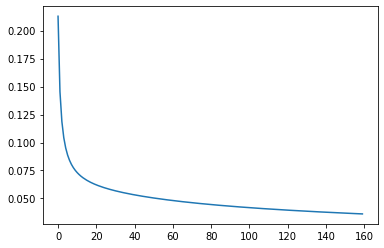

In [8]:
# plot the loss after each epoch
plt.plot(range(len(cost)), cost)

In [9]:
# make predictions on the test set
print(logreg.predict(X_test))
print(f'Test Accuracy: {accuracy_score(y_test, logreg.predict(X_test))*100:.2f}%')

tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1])
Test Accuracy: 100.00%
